# 最適フィードバック制御モデル
ToDo: infiniteOFCと数式の統一を行う．

## 最適フィードバック制御モデルの構造
**最適フィードバック制御モデル (optimal feedback control; OFC)** の特徴として目標軌道を必要としないことが挙げられる．**Kalman フィルタ**による状態推定と**線形2次レギュレーター(LQR: linear-quadratic regurator)** により推定された状態に基づいて運動指令を生成という2つの流れが基本となる．

### 系の状態変化

$$
\begin{align}
&\text {Dynamics} \quad \mathbf{x}_{t+1}=A \mathbf{x}_{t}+B \mathbf{u}_{t}+\boldsymbol{\xi}_{t}+\sum_{i=1}^{c} \varepsilon_{t}^{i} C_{i} \mathbf{u}_{t}\\
&\text {Feedback} \quad \mathbf{y}_{t}=H \mathbf{x}_{t}+\omega_{t}+\sum_{i=1}^{d} \epsilon_{t}^{i} D_{i} \mathbf{x}_{t}\\
&\text{Cost per step}\quad \mathbf{x}_{t}^\top Q_{t} \mathbf{x}_{t}+\mathbf{u}_{t}^\top R \mathbf{u}_{t}
\end{align}
$$

### LQG
加法ノイズしかない場合($C=D=0$)，制御問題は**線形2次ガウシアン(LQG: linear-quadratic-Gaussian)制御**と呼ばれる．


#### 運動制御 (Linear-Quadratic Regulator)

$$
\begin{align}
\mathbf{u}_{t}&=-L_{t} \widehat{\mathbf{x}}_{t}\\
L_{t}&=\left(R+B^{\top} S_{t+1} B\right)^{-1} B^{\top} S_{t+1} A\\
S_{t}&=Q_{t}+A^{\top} S_{t+1}\left(A-B L_{t}\right)\\
s_t &= \mathrm{tr}(S_{t+1}\Omega^\xi) + s_{t+1}; s_T=0
\end{align}
$$

$\boldsymbol{S}_{T}=Q$

#### 状態推定 (Kalman Filter)

$$
\begin{align}
\widehat{\mathbf{x}}_{t+1}&=A \widehat{\mathbf{x}}_{t}+B \mathbf{u}_{t}+K_{t}\left(\mathbf{y}_{t}-H \widehat{\mathbf{x}}_{t}\right)+\boldsymbol{\eta}_{t} \\ 
K_{t}&=A \Sigma_{t} H^{\top}\left(H \Sigma_{t} H^{\top}+\Omega^{\omega}\right)^{-1} \\ 
\Sigma_{t+1}&=\Omega^{\xi}+\left(A-K_{t} H\right) \Sigma_{t} A^{\top}
\end{align}
$$

この場合に限り，運動制御と状態推定を独立させることができる．

### 一般化LQG
状態および制御依存ノイズがある場合，

## 実装
ライブラリの読み込みと関数の定義．

In [1]:
using Base: @kwdef
using Parameters: @unpack
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial") 

ToDo: struct 修正（nが両方に入っている）

In [2]:
@kwdef struct Reaching1DModelParameter
    n = 4 # number of dims
    p = 3 # 
    i = 0.25 # kgm^2, 
    b = 0.2 # kgm^2/s
    ta = 0.03 # s
    te = 0.04 # s
    L0 = 0.35 # m

    bu = 1 / (ta * te * i)
    α1 = bu * b
    α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
    α3 = b/i + 1/ta + 1/te

    A = [zeros(p) I(p); -[0, α1, α2, α3]']
    B = [zeros(p); bu]
    C = [I(p) zeros(p)]
    D = Diagonal([1e-3, 1e-2, 5e-2])

    Y = 0.02 * B
    G = 0.03 * I(n)
end

@kwdef struct Reaching1DModelCostParameter
    n = 4
    dt = 1e-2 # sec
    T = 0.5 # sec
    nt = round(Int, T/dt) # num time steps
    Q = [zeros(nt-1, n, n); reshape(Diagonal([1.0, 0.1, 1e-3, 1e-4]), (1, n, n))]
    R = 1e-4 / nt
    
    init_pos = -0.5
    x₁ = [init_pos; zeros(n-1)]#zeros(n)
    Σ₁ = zeros(n, n)
end

Reaching1DModelCostParameter

Qの値は各時刻において一般座標 (位置，速度，加速度，躍度)のそれぞれを0にするコストに対する重みづけである．例えば，速度も0にすることを重視すれば2番目の係数を上げる．

$S$と$\Sigma$は各時点での値を一時的にしか必要としないので更新する．

In [3]:
function LQG(param::Reaching1DModelParameter, cost_param::Reaching1DModelCostParameter; discrete=true)
    @unpack n, p, A, B, C, D, G = param
    @unpack Q, R, x₁, Σ₁, dt, nt = cost_param

    if discrete
        A = I + A * dt
        B = B * dt
        C = C * dt
        D = sqrt(dt) * D
        G = sqrt(dt) * G
    end
    
    L = zeros(nt-1, n) # Feedback gains
    K = zeros(nt-1, n, p) # Kalman gains
    S = copy(Q[end, :, :]) # S_T = Q
    Σ = copy(Σ₁);

    for t in 1:nt-1
        K[t, :, :] = A * Σ * C' / (C * Σ * C' + D) # update K
        Σ = G + (A - K[t, :, :] * C) * Σ * A'      # update Σ
    end　

    cost = 0
    for t in nt-1:-1:1
        cost += tr(S * G)
        L[t, :] = (R + B' * S * B) \ B' * S * A # update L
        S = Q[t, :, :] + A' * S * (A - B * L[t, :]')     # update S
    end
    
    # adjust cost
    cost += x₁' * S * x₁
    return L, K, cost
end

LQG (generic function with 1 method)

### シミュレーション
信号依存ノイズ Yが入っている場合はLQGとは異なってくる．

$$
\begin{align}
&\mathbf{u}_{t}=-L_{t} \hat{\mathbf{x}}_{t} \\
&L_{t}=\left(B^\top S_{t+1}^{\mathbf{x}} B+R+\sum_{n} C_{n}^\top\left(S_{t+1}^{\mathbf{x}}+S_{t+1}^{\mathrm{e}}\right) C_{n}\right)^{-1} B^\top S_{t+1}^{\mathbf{x}} A \\
&S_{t}^{\mathbf{x}}=Q_{t}+A^\top S_{t+1}^{\mathbf{x}}\left(A-B L_{t}\right) ; \quad S_{T}^{\mathbf{x}}=Q_{T} \\
&S_{t}^{\mathrm{e}}=A^\top S_{t+1}^{\mathbf{x}} B L_t+\left(A-K_{t} H\right)^\top S_{t+1}^{\mathrm{e}}\left(A-K_{t} H\right) ; \quad S_{T}^{\mathrm{e}}=0\\
&s_{t}=\operatorname{tr}\left(S_{t+1}^{\mathrm{x}}\Omega^{\xi}+S_{t+1}^{\mathrm{e}}\left(\Omega^{\xi}+\Omega^{\eta}+K_{t} \Omega^{\omega} K_{t}^{\top}\right)\right)+s_{t+1} ; \quad s_{n}=0 .
\end{align}
$$

$$
\begin{align}
\hat{\mathbf{x}}_{t+1} &=A \hat{\mathbf{x}}_{t}+B \mathbf{u}_{t}+K_{t}\left(\mathbf{y}_{t}-H \hat{\mathbf{x}}_{t}\right) \\
K_{t} &=A \Sigma_{t}^{\mathrm{e}} H^\top\left(H \Sigma_{t}^{\mathrm{e}} H^\top+\Omega^{\omega}\right)^{-1} \\
\Sigma_{t+1}^{\mathrm{e}} &=\left(A-K_{t} H\right) \Sigma_{t}^{\mathrm{e}} A^\top+\sum_{n} C_{n} L_{t} \Sigma_{t}^{\hat{x}} L_{t}^\top C_{n}^\top ; \quad \Sigma_{1}^{\mathrm{e}}=\Sigma_{1} \\
\Sigma_{t+1}^{\hat{\mathbf{x}}} &=K_{t} H \Sigma_{t}^{\mathrm{e}} A^\top+\left(A-B L_{t}\right) \Sigma_{t}^{\hat{\mathbf{x}}}\left(A-B L_{t}\right)^\top ; \quad \Sigma_{1}^{\hat{\mathbf{x}}}=\hat{\mathbf{x}}_{1} \hat{\mathbf{x}}_{1}^\top
\end{align}
$$

In [4]:
function gLQG(param::Reaching1DModelParameter, cost_param::Reaching1DModelCostParameter, maxiter=200, ϵ=1e-8)
    @unpack n, p, A, B, C, D, Y, G = param
    @unpack Q, R, x₁, Σ₁, dt, nt = cost_param

    A = I + A * dt
    B = B * dt
    C = C * dt
    D = sqrt(dt) * D
    G = sqrt(dt) * G
    Y = sqrt(dt) * Y
    
    L = zeros(nt-1, n) # Feedback gains
    K = zeros(nt-1, n, p) # Kalman gains
    
    cost = zeros(maxiter)
    for i in 1:maxiter
        Sˣ = copy(Q[end, :, :])
        Sᵉ = zeros(n, n)
        Σˣ̂ = x₁ * x₁' # \Sigma TAB \^x TAB \hat TAB
        Σᵉ = copy(Σ₁)
        
        for t in 1:nt-1
            K[t, :, :] = A * Σᵉ * C' / (C * Σᵉ * C' + D)

            AmBL = A - B * L[t, :]'
            LΣˣ̂L = L[t, :]' * Σˣ̂ * L[t, :]

            Σˣ̂ = K[t, :, :] * C * Σᵉ * A' + AmBL * Σˣ̂ * AmBL'
            Σᵉ = G + (A - K[t, :, :] * C) * Σᵉ * A' + Y * LΣˣ̂L * Y'
        end
        
        for t in nt-1:-1:1
            cost[i] += tr(Sˣ * G + Sᵉ * (G + K[t, :, :] * D * K[t, :, :]'))
            
            L[t, :] = (R + B' * Sˣ * B + Y' * (Sˣ + Sᵉ) * Y) \ B' * Sˣ * A

            AmKC = A - K[t, :, :] * C
            Sᵉ = A' * Sˣ * B * L[t, :]' + AmKC' * Sᵉ * AmKC
            Sˣ = Q[t, :, :] + A' * Sˣ * (A - B * L[t, :]')
        end
        
        # adjust cost
        cost[i] += x₁' * Sˣ * x₁ + tr((Sˣ + Sᵉ) * Σ₁)
        if i > 1 && abs(cost[i] - cost[i-1]) < ϵ
            cost = cost[1:i]
            break
        end
    end
    return L, K, cost
end

gLQG (generic function with 3 methods)

状態ノイズがある場合に関してはTodorovのMATLABコード <https://homes.cs.washington.edu/~todorov/software/gLQG.zip>を参照．

位置は目標位置を基準とする座標で表現し，位置が0になるように運動を行う．状態の中に標的位置を含めコストパラメータを修正することで初期位置を基準とする座標系での運動を記述できる．モデルに関してはTodorov2005を参照．

In [5]:
function simulation(param::Reaching1DModelParameter, cost_param::Reaching1DModelCostParameter, 
                    L, K; noisy=false)
    @unpack n, p, A, B, C, D, Y, G = param
    @unpack Q, R, x₁, dt, nt = cost_param
    
    X = zeros(n, nt)
    u = zeros(nt)
    X[:, 1] = x₁ # m; initial position (target position is zero)

    if noisy
        sqrtdt = √dt
        X̂ = zeros(n, nt)
        X̂[1, 1] = X[1, 1]
        for t in 1:nt-1
            u[t] = -L[t, :]' * X̂[:, t]
            X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt + sqrtdt * (Y * u[t] * randn() + G * randn(n))
            dy = C * X[:,t] * dt + D * sqrtdt * randn(n-1)
            X̂[:, t+1] = X̂[:,t] + (A * X̂[:,t] + B * u[t]) * dt + K[t, :, :] * (dy - C * X̂[:,t] * dt)
        end
    else
        for t in 1:nt-1
            u[t] = -L[t, :]' * X[:, t]
            X[:, t+1] = X[:, t] + (A * X[:, t] + B * u[t]) * dt
        end
    end
    return X, u
end

simulation (generic function with 1 method)

In [6]:
function simulation_all(param, cost_param, L, K)
    Xa, ua = simulation(param, cost_param, L, K, noisy=false);
    
    # noisy
    nsim = 10
    XSimAll = []
    uSimAll = []
    for i in 1:nsim
        XSim, u = simulation(param, cost_param, L, K, noisy=true);
        push!(XSimAll, XSim)
        push!(uSimAll, u)
    end
    
    # visualization
    @unpack dt, T = cost_param
    tarray = collect(dt:dt:T)
    label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]

    fig, ax = subplots(1, 3, figsize=(10, 3))
    for i in 1:2
        for j in 1:nsim
            ax[i].plot(tarray, XSimAll[j][i,:]', "tab:gray", alpha=0.5)
        end

        ax[i].plot(tarray, Xa[i,:], "tab:red")
        ax[i].set_ylabel(label[i]); ax[i].set_xlabel(L"Time ($s$)"); 
        ax[i].set_xlim(0, T); ax[i].grid()
    end

    for j in 1:nsim
        ax[3].plot(tarray, uSimAll[j], "tab:gray", alpha=0.5)
    end
    ax[3].plot(tarray, ua, "tab:red")
    ax[3].set_ylabel(L"Control signal ($N\cdot m$)"); ax[3].set_xlabel(L"Time ($s$)"); 
    ax[3].set_xlim(0, T); ax[3].grid()

    tight_layout()
end

simulation_all (generic function with 1 method)

In [7]:
param = Reaching1DModelParameter()
cost_param = Reaching1DModelCostParameter();

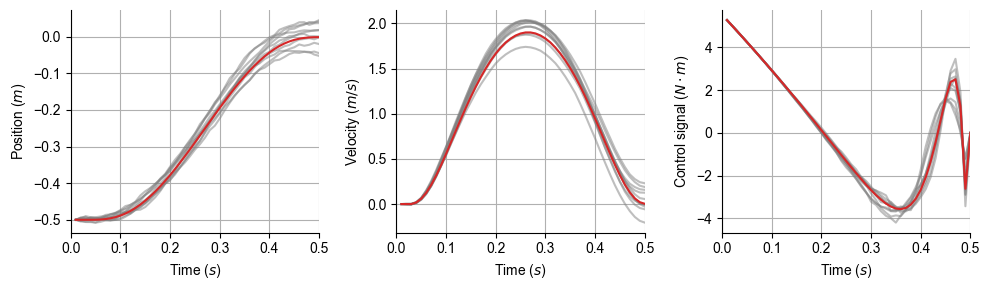

In [8]:
L, K, cost = LQG(param, cost_param);
simulation_all(param, cost_param, L, K)

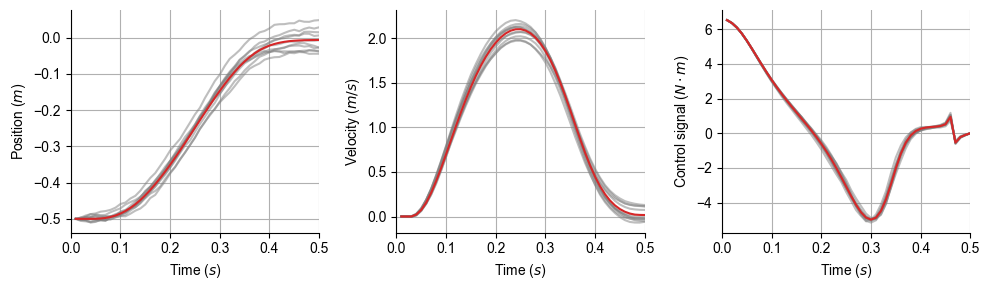

In [9]:
L, K, cost = gLQG(param, cost_param);
simulation_all(param, cost_param, L, K)

## 参考文献
```{bibliography}
:filter: docname in docnames
```